In [1]:
import numpy as np
from numpy import random
import scipy as sp
import newick

import matplotlib.pyplot as plt

from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut
from prosstt import count_model as cm

In [2]:
newick1 = "(A,B)C;"
tree1 = newick.loads(newick1)
G = 500
lineage = tree.Tree.from_newick(newick1, genes=G)

visualize the topology

In [3]:
print(tree1[0].ascii_art())

    ┌─A
──C─┤
    └─B


confirm that the density in the tree sums up to 1

In [4]:
tree_density = lineage.default_density()
total_density = 0
for branch in lineage.branches:
    total_density += np.sum(tree_density[branch])
print(total_density)

1.0


define a non-homogeneous density: let's say we want a normal distribution to describe the cell density during pseudotime. In a single bifurcation like this one, this means that the branch 'A' will have a density of the left half of a gaussian and branches 'B' and 'C' will have half the density of the right half of a gaussian:

In [5]:
# first half, going up to the branch point
# half a normal distribution, so we halve the PDF
mmin = -4
mmax = 0
steps = 40
step_size = np.abs(mmax - mmin) / steps
pos = np.arange(mmin, mmax, step_size)
len(pos)
mynorm = sp.stats.norm()
branch0 = mynorm.pdf(pos) / 2
# second half, going down from the branch point
# two times since we want it for both new branches
mmin = 0
mmax = 4
steps = 40
step_size = np.abs(mmax - mmin) / steps
pos = np.arange(mmin, mmax, step_size)
branch12 = mynorm.pdf(pos) / 4
total_density = np.sum(branch0) + np.sum(branch12) +np.sum(branch12)

In [6]:
# use densities and normalize to make sure it adds up to 1
# so that the probabilistic sampling makes sense
density = {}
density['C'] = branch0 / total_density
density['B'] = branch12 / total_density
density['A'] = branch12 / total_density
lineage.density = density

In [7]:
alpha, beta = cm.generate_negbin_params(lineage)
lineage.default_gene_expression()

/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [8]:
X, labels, branches, scalings = sim.sample_density(lineage, 300, alpha=alpha, beta=beta)

plot the density of the pseudotime points present in each branch to see that they conform with the density function we defined

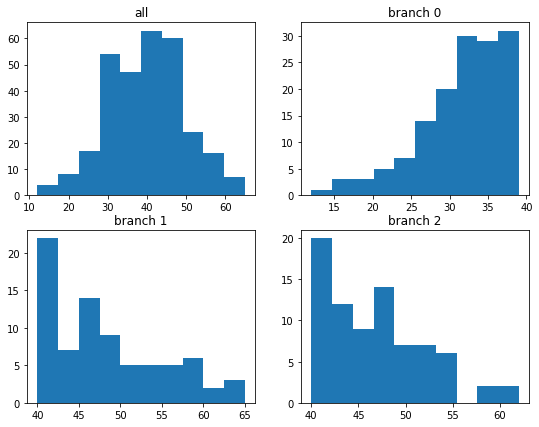

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(w=9, h=7)
ax[0, 0].hist(labels)
ax[0, 0].set_title("all")
ax[0, 1].hist(labels[branches=='C'])
ax[0, 1].set_title("branch 0")
ax[1, 0].hist(labels[branches=='A'])
ax[1, 0].set_title("branch 1")
ax[1, 1].hist(labels[branches=='B'])
ax[1, 1].set_title("branch 2")
plt.show()